The project focuses on visualising overall event volume in 15-minute intervals, with the ability to drill down and see which Event IDs were recorded during each interval.

In [25]:
# libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import Layout

In [26]:
# bring csv into a dataframe
data = pd.read_csv('mock_data.csv')
pd.set_option('display.max_colwidth', None)

<ipython-input-26-00d1e36c76bc>:2: DtypeWarning: Columns (15,16,74) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('mock_data.csv')


# Understanding hit volume by 15-min interval

In [ ]:
# create a base table for timestamp
timestamp_table = data['timestamp']

In [ ]:
# extract the hour
time_hour = timestamp_table.str.extract(r'(\d{2}):\d{2}:\d{2}')

# rename the column to hour
time_hour.columns=['hour']
time_hour.head()

In [ ]:
# extract the minute
time_min = timestamp_table.str.extract(r'\d{2}:(\d{2}):\d{2}')

# change datatype from object to integer
time_min[0] = pd.to_numeric(time_min[0], errors='coerce')
time_min.head()

In [ ]:
# create a new column and extract minute interval
time_min['min'] = np.where(time_min[0] >= 45, '45-60', np.where((time_min[0] >= 30) & (time_min[0] < 45), '30-45', np.where((time_min[0] >=15) & (time_min[0] < 30), '15-30', '0-15')))
time_min.head()

In [ ]:
# combine timestamp, event ids, hour, min into time_dist dataframe
time_dist = pd.concat([data['timestamp'], data['winlog.event_id'], time_hour['hour'], time_min['min']], axis=1)
time_dist.head()

In [ ]:
# create a groupby table for the event count by time interval
time_calc = time_dist.groupby(['hour','min']).size().reset_index(name="count")
time_calc.head()

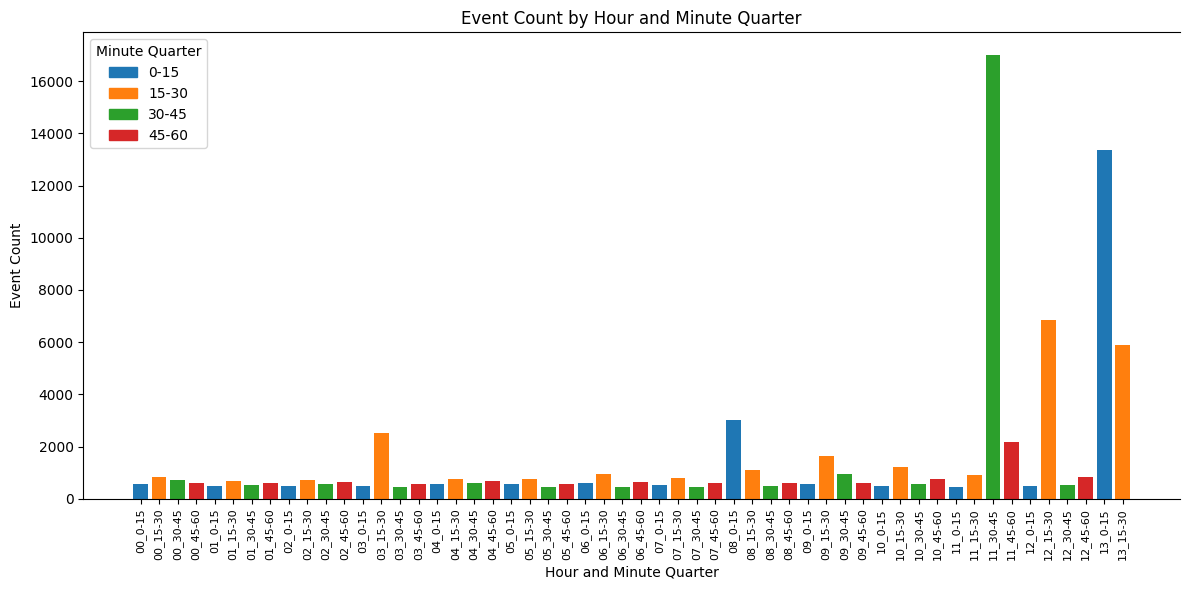

In [44]:
## visualise the time_calc table

# create a new column combining hour and minute quarter for x-axis labels
time_calc['hour_min'] = time_calc['hour'].astype(str) + '_' + time_calc['min']

fig, ax = plt.subplots(figsize=(12, 6))

# plot the bars using the new 'hour_min' column
#ax.bar(time_calc['hour_min'], time_calc['count'])
ax.bar(time_calc['hour_min'], time_calc['count'], color=plt.colormaps.get_cmap('tab10')(pd.factorize(time_calc['min'])[0]))
ax.set_xlabel('Hour and Minute Quarter')
ax.set_ylabel('Event Count')
ax.set_title('Event Count by Hour and Minute Quarter')

# rotate x-axis labels + adjust font size
plt.xticks(rotation=90, fontsize=8)

# legend
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=plt.colormaps.get_cmap('tab10')(i), label=q) for i, q in enumerate(time_calc['min'].unique())], title='Minute Quarter', loc='upper left')

plt.gca().spines[['right']].set_visible(False)
plt.tight_layout()
plt.show()



---



# Interactive visualisation to understand the time recorded of specific Event IDs

In [ ]:
# create a groupby table for the event count by event id and time interval
event_count_calc = time_dist.groupby(['hour','min', 'winlog.event_id']).size().reset_index(name="count")
event_count_calc.head()

In [50]:
## visualise the event_count_calc table along with ability to select specific event ids, in the example here the selected IDs are 8, 29, 4648, and 4732

# element 1: multiple select | get unique event id value to for multiple select
unique_values_a = sorted(event_count_calc['winlog.event_id'].unique().tolist())

# element 1: multiple select | create widget for multiple select
multiple_select = widgets.SelectMultiple(
    options=unique_values_a,
    value=[],  # Default is no selection
    description='Show Event IDs:',
    disabled=False,
    style={'description_width': 'initial'}
)

# element 2: plot button | create widget for plot button
plot_button = widgets.Button(description='Plot')

# element 3: reset button | create widget for reset Button
reset_button = widgets.Button(description='Reset')

# element 4: plot display | create a placeholder for the plot output
plot_output = widgets.Output()

# element 5: update plot | define function to update the bar chart
def update_plot(selected_values):
    with plot_output:
        plot_output.clear_output(wait=True) # clear the previous plot
        plt.figure(figsize=(10, 6))

        # create 'hour_min' column for grouping
        event_count_calc['hour_min'] = event_count_calc['hour'].astype(str) + '_' + event_count_calc['min']

        # get full, sorted list of all hour_min values for x-axis
        all_time_blocks = (event_count_calc['hour'].astype(str) + '_' + event_count_calc['min']).drop_duplicates().sort_values().tolist()

        # filter by selected event IDs if any
        if selected_values:
            filtered_df = event_count_calc[event_count_calc['winlog.event_id'].isin(selected_values)]
        else:
            filtered_df = event_count_calc.copy()

        # pivot the data for stacking: rows are hour_min, columns are event IDs
        pivot_df = filtered_df.pivot_table(
            index='hour_min',
            columns='winlog.event_id',
            values='count',
            aggfunc='sum',
            fill_value=0
        )
        # reindex pivot_df so x-axis always has the full time range
        pivot_df = pivot_df.reindex(all_time_blocks, fill_value=0)

        x = range(len(pivot_df.index))
        bottom = [0] * len(pivot_df.index)

        # plot each event_id's counts stacked on top of each other
        for i, column in enumerate(pivot_df.columns):
            plt.bar(x, pivot_df[column], bottom=bottom, label=str(column))
            bottom = [b + v for b, v in zip(bottom, pivot_df[column])]

        plt.xticks(x, pivot_df.index, rotation=45, ha='right')
        plt.xlabel('Hour and Minute Quarter')
        plt.xticks(rotation=90, fontsize=6)
        plt.ylabel('Event Count')
        plt.title('Event IDs by Hour and Minute Quarter')
        plt.legend(title='Event ID', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

# element 2: plot button | define function for Plot button click
# update the plot using the values from multi select widget as input
def on_plot_button_clicked(b):
    update_plot(multiple_select.value)

# element 3: reset button | define function for Reset button click
# update the plot using a forced empty multi select
def on_reset_button_clicked(b):
    multiple_select.value = []
    update_plot([])

# element 3: reset button | connect the Reset button click event with corresponding function
reset_button.on_click(on_reset_button_clicked)

# element 2: plot button | connect the Plot button click event with the function
plot_button.on_click(on_plot_button_clicked)

# element 4: plot display | display the widgets and the plot output
display(multiple_select, widgets.HBox((plot_button, reset_button)), plot_output)

# Initial display of the full plot (as per default)
update_plot([])

SelectMultiple(description='Show Event IDs:', options=(1, 2, 3, 7, 8, 10, 11, 12, 13, 17, 18, 22, 26, 29, 4624…

Output()



---

